In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping



In [13]:

# GPU 설정
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

Num GPUs Available:  1


In [34]:
data_path = "/content/drive/MyDrive/lg_data/train.csv"
test_path = "/content/drive/MyDrive/lg_data/test.csv"


In [47]:
df = pd.read_csv(data_path, encoding="utf-8-sig")
test_df = pd.read_csv(test_path, encoding="utf-8-sig")

df.columns = df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

In [48]:
# 불필요한 컬럼 제거
drop_columns = ["ID", "시술 시기 코드"]
df = df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

In [49]:
print(df.columns.tolist())  # 컬럼명을 리스트 형태로 출력


['시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '특정 시술 유형', '배란 자극 여부', '배란 유도 유형', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 여성 요인', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 채취 경과일', '난자 해동 경과일', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부']


In [50]:
from sklearn.preprocessing import LabelEncoder

# 범주형 데이터 컬럼 목록 확인
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# LabelEncoder 저장용 딕셔너리
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()

    # 훈련 데이터로 Label Encoding 학습
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

    # 🛠 **테스트 데이터 변환 시 예외 처리**
    test_df[col] = test_df[col].astype(str).apply(lambda x: x if x in le.classes_ else "Unknown")

    # 새로운 값이 생기면 기존 classes에 추가 후 변환
    le.classes_ = np.append(le.classes_, "Unknown")
    test_df[col] = le.transform(test_df[col])


In [55]:
# "임신 성공 여부" 컬럼이 훈련 데이터(df)에는 있지만, 테스트 데이터(test_df)에는 없음
# ✅ X_train, y_train 분리
X_train = df.drop(columns=["임신 성공 여부"])  # 입력 데이터
y_train = df["임신 성공 여부"]  # 타겟 변수

# ✅ X_test는 test_df에서 동일한 입력 데이터만 사용
X_test = test_df  # test_df에는 "임신 성공 여부" 컬럼이 없으므로 그대로 사용

print("✅ X_train 컬럼 목록:", X_train.columns.tolist())
print("✅ X_test 컬럼 목록:", X_test.columns.tolist())  # 비교 확인


✅ X_train 컬럼 목록: ['시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '특정 시술 유형', '배란 자극 여부', '배란 유도 유형', '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인', '부부 부 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 여성 요인', '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수', '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이', '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부', '난자 채취 경과일', '난자 해동 경과일', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일']
✅ X_test 컬럼 목록: ['시술 당시 나이', '

In [58]:
from sklearn.preprocessing import LabelEncoder

# 범주형 컬럼 찾기
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

# 각 컬럼에 대해 Label Encoding 수행
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()

    # 훈련 데이터에 Label Encoding 적용
    X_train[col] = le.fit_transform(X_train[col].astype(str))

    # 테스트 데이터에도 동일한 Label Encoding 적용 (예외처리 포함)
    X_test[col] = X_test[col].astype(str).apply(lambda x: x if x in le.classes_ else "Unknown")
    le.classes_ = np.append(le.classes_, "Unknown")  # 새로운 값 처리
    X_test[col] = le.transform(X_test[col])

    # Label Encoder 저장
    label_encoders[col] = le

print("✅ 범주형 데이터 Label Encoding 완료!")


✅ 범주형 데이터 Label Encoding 완료!


In [59]:
from sklearn.preprocessing import StandardScaler

# 숫자형 컬럼 선택
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# StandardScaler 적용
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])  # 테스트 데이터도 동일 변환

print("✅ 데이터 정규화 완료!")


✅ 데이터 정규화 완료!


In [60]:
from sklearn.model_selection import train_test_split

# 훈련 데이터 (80%) / 검증 데이터 (20%) 분할
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("✅ 훈련 데이터 크기:", X_train_final.shape)
print("✅ 검증 데이터 크기:", X_val.shape)


✅ 훈련 데이터 크기: (205080, 66)
✅ 검증 데이터 크기: (51271, 66)


In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 모델 정의
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류이므로 sigmoid 사용
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping 설정 (과적합 방지)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
model.fit(X_train_final, y_train_final,
          validation_data=(X_val, y_val),
          epochs=50, batch_size=32,
          callbacks=[early_stopping], verbose=1)

print("✅ 모델 학습 완료!")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6409/6409 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.7402 - loss: 0.5147 - val_accuracy: 0.7457 - val_loss: 0.4908
Epoch 2/50
6409/6409 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.7427 - loss: 0.4951 - val_accuracy: 0.7461 - val_loss: 0.4899
Epoch 3/50
6409/6409 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7435 - loss: 0.4929 - val_accuracy: 0.7455 - val_loss: 0.4902
Epoch 4/50
6409/6409 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7450 - loss: 0.4916 - val_accuracy: 0.7451 - val_loss: 0.4898
Epoch 5/50
6409/6409 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.7434 - loss: 0.4929 - val_accuracy: 0.7468 - val_loss: 0.4896
Epoch 6/50
6409/6409 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7431 - loss: 0.4934 - val_accuracy: 0.7469 - val_loss: 0.4890
Epoch 7/50
6409/6409 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.7435 - loss: 0.4921 - val_accuracy: 0.7468 - val_loss: 0.4894
Epoch 8/50
6409/6409 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7467 - loss: 0

In [64]:
# 검증 데이터 평가
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"검증 데이터 손실값: {val_loss:.4f}")
print(f"검증 데이터 정확도(Accuracy): {val_acc:.4f}")


1603/1603 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7521 - loss: 0.4829
검증 데이터 손실값: 0.4880
검증 데이터 정확도(Accuracy): 0.7477


In [66]:
# 테스트 데이터 예측값 계산
test_predictions = model.predict(X_test)
test_predictions = (test_predictions > 0.5).astype(int)

# 테스트 데이터 예측값 분포 확인
print("✅ 테스트 데이터 예측값 분포:")
print(pd.Series(test_predictions.flatten()).value_counts())


2815/2815 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
✅ 테스트 데이터 예측값 분포:
0    87155
1     2912
Name: count, dtype: int64


In [69]:
# 훈련 데이터에서 예측값 생성
y_train_pred = model.predict(X_train)
y_train_pred = (y_train_pred > 0.5).astype(int)  # 확률을 0 또는 1로 변환

# 훈련 데이터에서 성공(1)의 비율
train_success_ratio = y_train_pred.mean()

# 테스트 데이터에서 성공(1)의 비율
test_success_ratio = test_predictions.mean()

print(f"✅ 훈련 데이터에서 성공 비율: {train_success_ratio:.4f}")
print(f"✅ 테스트 데이터에서 성공 비율: {test_success_ratio:.4f}")
print(f"✅ 두 데이터셋의 비율 차이: {abs(train_success_ratio - test_success_ratio):.4f}")


8011/8011 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
✅ 훈련 데이터에서 성공 비율: 0.0318
✅ 테스트 데이터에서 성공 비율: 0.0323
✅ 두 데이터셋의 비율 차이: 0.0005


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

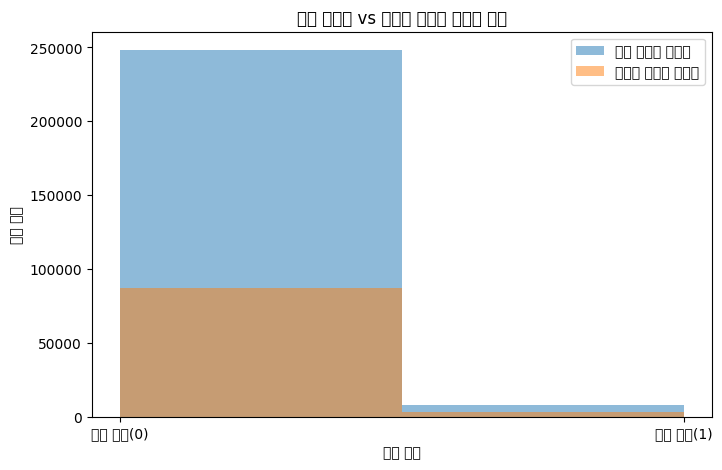

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(y_train_pred, bins=2, alpha=0.5, label="훈련 데이터 예측값")
plt.hist(test_predictions, bins=2, alpha=0.5, label="테스트 데이터 예측값")
plt.xticks([0, 1], ["임신 실패(0)", "임신 성공(1)"])
plt.xlabel("예측 결과")
plt.ylabel("샘플 개수")
plt.title("훈련 데이터 vs 테스트 데이터 예측값 비교")
plt.legend()
plt.show()